# TSFRESH Human Activity Recognition Example
This example show shows how to use [tsfresh](https://tsfresh.readthedocs.io/) to exctract useful features from multiple timeseries and use them to improve classification performance.

In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import seaborn as sns
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import FeatureExtractionSettings
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np

/usr/local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Load and visualize data
The dataset consists of timeseries for 7352 accelerometer readings. Each reading represents an accelerometer reading for 2.56 sec at 50hz (for a total of 128 samples per reading). Furthermore, each reading corresponds one of six activities (walking, walking upstairs, walking downstairs, sitting, standing and laying)

For more information, or to fetch dataset, go to https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones

In [2]:
df = pd.read_csv('data/body_acc_x_train.txt', delim_whitespace=True, header=None)

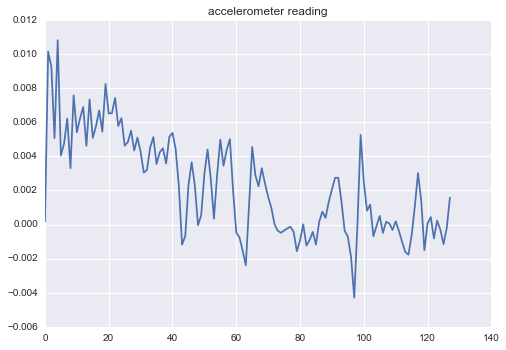

In [3]:
plt.title('accelerometer reading')
plt.plot(df.ix[0,:])

## Extract Features

In [4]:
extraction_settings = FeatureExtractionSettings()
extraction_settings.IMPUTE = impute    # Fill in Infs and NaNs

In [5]:
# transpose since tsfresh reads times series data column-wise, not row-wise
df_t = df.copy().transpose()
df_t.shape

(128, 7352)

In [6]:
# rearrange sensor readings column-wise, not row-wise

master_df = pd.DataFrame(df_t[0])
master_df['id'] = 0

for i in range(1, 500):
    temp_df = pd.DataFrame(df_t[i])
    temp_df['id'] = i
    master_df = pd.DataFrame(np.vstack([master_df, temp_df]))

In [7]:
%time X = extract_features(master_df, column_id=1, feature_extraction_settings=extraction_settings);

/usr/local/lib/python2.7/site-packages/pandas/computation/expressions.py:182: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))
/usr/local/lib/python2.7/site-packages/scipy/signal/spectral.py:772: UserWarning: nperseg = 256, is greater than input length = 128, using nperseg = 128
  'using nperseg = {1:d}'.format(nperseg, x.shape[-1]))


CPU times: user 1min, sys: 243 ms, total: 1min
Wall time: 1min


In [8]:
# 206 features are quickly extracted for each reading

X.shape

(500, 206)

## Train and evaluate classifier

In [9]:
y = pd.read_csv('data/y_train.txt', delim_whitespace=True, header=None)[:500]

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

In [11]:
cl = DecisionTreeClassifier()
cl.fit(X_train, y_train)
print(classification_report(y_test, cl.predict(X_test)))

             precision    recall  f1-score   support

          1       1.00      0.96      0.98        28
          2       0.94      1.00      0.97        17
          3       0.92      0.92      0.92        13
          4       0.92      0.85      0.88        13
          5       0.95      0.95      0.95        19
          6       0.82      0.90      0.86        10

avg / total       0.94      0.94      0.94       100



## Compare against naive classification accuracy
By extracting using tsfresh features, we can meaningfully increase accuracy.

In [12]:
X_1 = df.ix[:499,:]
X_1.shape

(500, 128)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_1, y, test_size=.2)

In [14]:
cl = DecisionTreeClassifier()
cl.fit(X_train, y_train)
print(classification_report(y_test, cl.predict(X_test)))

             precision    recall  f1-score   support

          1       0.48      0.60      0.54        25
          2       0.56      0.42      0.48        12
          3       0.55      0.32      0.40        19
          4       0.16      0.30      0.21        10
          5       0.46      0.32      0.37        19
          6       0.24      0.27      0.25        15

avg / total       0.43      0.39      0.40       100

